In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import seaborn as sns

%matplotlib inline

In [2]:
from scripts.cleaner import logFile

In [3]:
file = '~/SageMaker/CreatingIPProfiles/log20101010.csv'

In [4]:
log = logFile(file)

In [5]:
df = log.extract()

In [6]:
df1 = log.transformer(df)

,ip,date,time,accession,datetime
datetime,,,,,
2010-10-10,108.5.109.gch,2010-10-10,00:00:00,0000950137-01-501552,2010-10-10
2010-10-10,108.5.109.gch,2010-10-10,00:00:00,0000950137-01-503045,2010-10-10
2010-10-10,108.5.109.gch,2010-10-10,00:00:00,0000950137-01-501552,2010-10-10
2010-10-10,209.223.222.jdd,2010-10-10,00:00:00,0001209191-10-049878,2010-10-10
2010-10-10,209.223.222.jdd,2010-10-10,00:00:00,0001144204-10-053151,2010-10-10


In [37]:
def filterer(df, iphitsmax=200, iphitsmin=30, dochitsmax=180, dochitsmin=35):
    #cumulative counts
    df['ip_ccount'] = df.groupby(df.ip).cumcount()+1
    df['doc_ccount'] = df.groupby(df.accession).cumcount()+1
    #total counts
    df['ip_total_count'] = df.groupby(df.ip, sort=False)['ip_ccount'].transform(max)
    df['doc_total_count'] = df.groupby(df.ip, sort=False)['doc_ccount'].transform(max)
    df = df.query('@iphitsmax > ip_total_count > @iphitsmin') 
    return df.query('@dochitsmax > doc_total_count > @dochitsmin')

In [38]:
df_filtered = filterer(df1)

In [39]:
df_filtered.head()

,ip,date,time,accession,datetime,ip_ccount,doc_ccount,ip_total_count,doc_total_count
datetime,,,,,,,,,
2010-10-10 00:02:06,151.191.175.eaj,2010-10-10,00:02:06,0001045769-10-000006,2010-10-10 00:02:06,1,1,142,100
2010-10-10 00:02:44,207.38.172.jde,2010-10-10,00:02:44,0000950123-09-064496,2010-10-10 00:02:44,1,1,145,48
2010-10-10 00:02:49,207.38.172.jde,2010-10-10,00:02:49,0000892569-09-000610,2010-10-10 00:02:49,2,1,145,48
2010-10-10 00:02:51,207.38.172.jde,2010-10-10,00:02:51,0000892569-09-000610,2010-10-10 00:02:51,3,2,145,48
2010-10-10 00:05:09,63.118.180.aji,2010-10-10,00:05:09,0001047469-10-007200,2010-10-10 00:05:09,1,1,98,68


In [40]:
df_original = df1

In [41]:
def stats(df_original, df_filtered):
    df_original = df_original.drop(['ip_ccount', 'doc_ccount'],axis=1)
    print(df_original.describe())
    print(df_filtered.describe())
    unique_docs_original = len(list(df_original.accession.unique()))
    unique_ips_original = len(list(df_original.ip.unique()))
    unique_docs_filtered = len(list(df_filtered.accession.unique()))
    unique_ips_filtered = len(list(df_filtered.ip.unique()))
    print("\nEvents: {}\nSample Size: {}\nPercent: {:2f}"
          .format(df_original.ip.count(), df_filtered.ip.count(), (df_filtered.ip.count()/df_original.ip.count())))
    print("Documents in Original: {}\nDocuments in Sample: {}\nPercent: {:2f}"
          .format(unique_docs_original, unique_docs_filtered, (unique_docs_filtered/unique_docs_original)))
    print("IPs in Original: {}\nIPs in Sample: {}\nPercent: {:2f}"
          .format(unique_ips_original, unique_ips_filtered, (unique_ips_filtered/unique_ips_original)))

In [42]:
stats(df_original, df_filtered)

       ip_total_count  doc_total_count
count    2.136342e+06     2.136342e+06
mean     3.226755e+05     9.077406e+03
std      2.892350e+05     1.038424e+04
min      1.000000e+00     1.000000e+00
25%      3.381700e+04     1.926000e+03
50%      4.221100e+05     2.504000e+03
75%      6.861230e+05     2.273000e+04
max      6.861230e+05     2.539600e+04
          ip_ccount    doc_ccount  ip_total_count  doc_total_count
count  16413.000000  16413.000000    16413.000000     16413.000000
mean      45.809480     19.516846       90.618961        76.380674
std       35.946154     28.487122       42.703089        35.377197
min        1.000000      1.000000       31.000000        36.000000
25%       18.000000      3.000000       55.000000        48.000000
50%       36.000000      6.000000       81.000000        66.000000
75%       65.000000     24.000000      125.000000        93.000000
max      187.000000    179.000000      187.000000       179.000000

Events: 2136342
Sample Size: 16413
Percent: 0

Text(0, 0.5, 'Count of Unique IP Addresses')

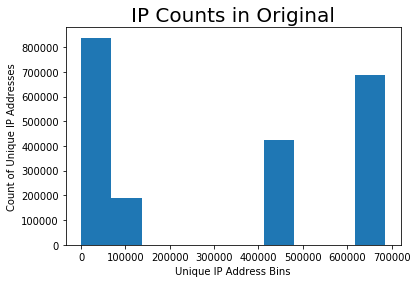

In [43]:
#plot count for IPs

plt.hist(df_original.ip_total_count)
plt.title("IP Counts in Original", fontsize=20)
plt.xlabel("Unique IP Address Bins")
plt.ylabel("Count of Unique IP Addresses")

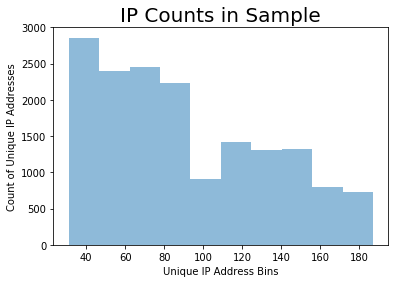

In [44]:
plt.hist(df_filtered.ip_total_count, alpha=0.5, label='Sample')
plt.title("IP Counts in Sample", fontsize=20)
plt.xlabel("Unique IP Address Bins")
plt.ylabel("Count of Unique IP Addresses")
plt.show()

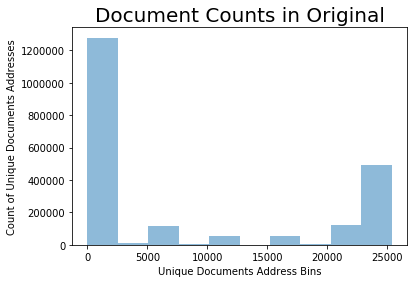

In [45]:
plt.hist(df_original.doc_total_count, alpha=0.5)
plt.title("Document Counts in Original", fontsize=20)
plt.xlabel("Unique Documents Address Bins")
plt.ylabel("Count of Unique Documents Addresses")
plt.show()

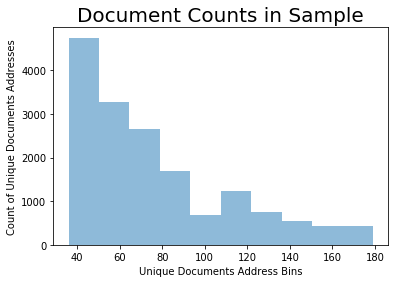

In [46]:
plt.hist(df_filtered.doc_total_count, alpha=0.5, label='Sample')
plt.title("Document Counts in Sample", fontsize=20)
plt.xlabel("Unique Documents Address Bins")
plt.ylabel("Count of Unique Documents Addresses")
plt.show()

In [47]:
def savetocsv(df, title):
    df = df.drop(['doc_total_count','ip_total_count'],axis=1)
    df.to_csv(title)

In [48]:
savetocsv(df_filtered, 'df_filtered.csv')